In [1]:
import tensorflow as tf

print("Tensorflow version " + tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print('CUda available: ', tf.test.is_built_with_cuda())

Tensorflow version 2.10.1
Num GPUs Available:  1
CUda available:  True


In [2]:
import zipfile

from keras.preprocessing.image import ImageDataGenerator

# tensor processing
import numpy as np
import os
from sklearn.utils import shuffle

# plotting
import matplotlib.pyplot as plt
from keras.utils import plot_model

# modeling
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, RandomFlip, RandomRotation
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

# evaluation metrics
from sklearn.metrics import classification_report
import pandas as pd

#model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50


import tifffile as tiff


In [3]:
z = zipfile.ZipFile('EuroSATallBands.zip')

In [4]:
# get file names
txtfiles = []
for file in z.namelist():
    print(file)
    txtfiles.append(file)

# keep only those containing ".tif"
txtfiles = [x for x in txtfiles if ".tif" in x]
print(txtfiles[:10])

ds/images/remote_sensing/otherDatasets/sentinel_2/tif/
ds/images/remote_sensing/otherDatasets/sentinel_2/tif/PermanentCrop/
ds/images/remote_sensing/otherDatasets/sentinel_2/tif/PermanentCrop/PermanentCrop_1619.tif
ds/images/remote_sensing/otherDatasets/sentinel_2/tif/PermanentCrop/PermanentCrop_1278.tif
ds/images/remote_sensing/otherDatasets/sentinel_2/tif/PermanentCrop/PermanentCrop_876.tif
ds/images/remote_sensing/otherDatasets/sentinel_2/tif/PermanentCrop/PermanentCrop_404.tif
ds/images/remote_sensing/otherDatasets/sentinel_2/tif/PermanentCrop/PermanentCrop_372.tif
ds/images/remote_sensing/otherDatasets/sentinel_2/tif/PermanentCrop/PermanentCrop_713.tif
ds/images/remote_sensing/otherDatasets/sentinel_2/tif/PermanentCrop/PermanentCrop_1456.tif
ds/images/remote_sensing/otherDatasets/sentinel_2/tif/PermanentCrop/PermanentCrop_1824.tif
ds/images/remote_sensing/otherDatasets/sentinel_2/tif/PermanentCrop/PermanentCrop_1790.tif
ds/images/remote_sensing/otherDatasets/sentinel_2/tif/Permane

In [5]:
def normalizeBand(band):
    band_norm = np.interp(band, (band.min(), band.max()), (0, 1))
    return band_norm

In [6]:
import geopandas as gpd

XImages_MS = np.zeros([len(txtfiles), 64, 64, 13], dtype="float32")

i = 0
for pic in txtfiles:
    with tiff.TiffFile(z.open(pic)) as img:
        print(i)
        temp = np.moveaxis(img.asarray(), -1, 2)
        XImages_MS[i] = normalizeBand(temp)
        i += 1

del z

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [7]:
labs = np.empty(len(txtfiles), dtype='S20')
i = 0
for label in txtfiles:
    labs[i] = label.split('/')[6]
    i += 1

label_names, yLabels = np.unique(labs, return_inverse=True)

label_Dict = dict(zip(np.unique(yLabels), label_names))

smallest_class = np.argmin(np.bincount(yLabels))

# number of classes
num_classes = len(np.array(np.unique(yLabels)))
# observations in smallest class
smallest_class_obs = np.where(yLabels == smallest_class)[0]

# # Get 1000 observations from each class
indBal = np.empty(0, dtype=int)
for i in range(num_classes):
    indTemp = shuffle(np.where(yLabels == i)[0], random_state=42)[0:int(smallest_class_obs.shape[0] / 2)]
    indBal = np.concatenate([indBal, indTemp])

# # shuffle the balanced index
indBal = shuffle(indBal, random_state=42)

yBal = yLabels[indBal]
XBal = XImages_MS[indBal]

# X_train, X_test, y_train, y_test = train_test_split(XBal, yBal, stratify = yBal, train_size = 0.5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(XImages_MS, yLabels, stratify=yLabels, train_size=0.8,
                                                    random_state=42)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [8]:
y_test_true_tmp = np.argmax(y_test, axis=1)
label_count = np.unique(y_test_true_tmp, return_counts=True)[1]

In [9]:
# Define functions for evaluating model accuracy by class and overall

def eval_model_by_class(model, test_set):
    y_test_pred_tmp = model.predict(test_set)

    y_test_true = [label_Dict[x] for x in y_test_true_tmp]
    y_test_pred = [label_Dict[x] for x in y_test_pred_tmp]

    pred_df = pd.DataFrame({'y_true': y_test_true, 'y_pred': y_test_pred})
    pred_df['accurate_preds'] = pred_df.y_true == pred_df.y_pred
    pred_df = pred_df.groupby(['y_true']).sum().reset_index()
    pred_df['label_count'] = label_count
    pred_df['class_acc'] = pred_df.accurate_preds / pred_df.label_count
    pred_df = pred_df.sort_values(by='class_acc').reset_index()
    pred_df['overall_acc'] = sum(pred_df.accurate_preds) / sum(pred_df.label_count)
    pred_df = pred_df.sort_values('y_true').reset_index(drop=True)

    return (pred_df)


def find_wrong_preds(model, test_set):
    y_test_pred_tmp = model.predict(test_set)

    y_test_true = [label_Dict[x] for x in y_test_true_tmp]
    y_test_pred = [label_Dict[x] for x in y_test_pred_tmp]

    pred_df = pd.DataFrame({'y_true': y_test_true, 'y_pred': y_test_pred})
    pred_df['accurate_preds'] = pred_df.y_true == pred_df.y_pred
    # pred_df = pred_df.sort_values('y_true').reset_index(drop = True)
    pred_df = pred_df.sort_values('y_true')

    return (pred_df)

In [10]:
input_shape_MS = X_train.shape[1:]


In [11]:
# print learning rate each epoch to see if reduce_LR is working as expected
# https://stackoverflow.com/questions/48198031/keras-add-variables-to-progress-bar/48206009#48206009
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr

    return lr


optimizer = RMSprop(learning_rate=0.0001)
lr_metric = get_lr_metric(optimizer)

In [12]:

def change_model(model, new_input_shape=(None, 40, 40, 3)):
    # replace input shape of first layer
    model.layers[0].batch_input_shape = new_input_shape

    # rebuild model architecture by exporting and importing via json
    new_model = keras.models.model_from_json(model.to_json())

    # copy weights from old model to new one
    for layer in new_model.layers:
        try:
            layer.set_weights(model.get_layer(name=layer.name).get_weights())
            print("Loaded layer {}".format(layer.name))
        except:
            print("Could not transfer weights for layer {}".format(layer.name))

    return new_model

In [13]:
resnet50 = ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=input_shape_MS,
    pooling=None,
    classes=num_classes,
    
    classifier_activation="softmax",
)

E:\Satellite Image Classification_Eurosat_Sentinel2\.venv\lib\site-packages\keras\applications\resnet.py:159: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 13 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


In [14]:
resnet50 = change_model(resnet50, new_input_shape=(None, 64, 64, 13))

Loaded layer input_1
Loaded layer conv1_pad
Loaded layer conv1_conv
Loaded layer conv1_bn
Loaded layer conv1_relu
Loaded layer pool1_pad
Loaded layer pool1_pool
Loaded layer conv2_block1_1_conv
Loaded layer conv2_block1_1_bn
Loaded layer conv2_block1_1_relu
Loaded layer conv2_block1_2_conv
Loaded layer conv2_block1_2_bn
Loaded layer conv2_block1_2_relu
Loaded layer conv2_block1_0_conv
Loaded layer conv2_block1_3_conv
Loaded layer conv2_block1_0_bn
Loaded layer conv2_block1_3_bn
Loaded layer conv2_block1_add
Loaded layer conv2_block1_out
Loaded layer conv2_block2_1_conv
Loaded layer conv2_block2_1_bn
Loaded layer conv2_block2_1_relu
Loaded layer conv2_block2_2_conv
Loaded layer conv2_block2_2_bn
Loaded layer conv2_block2_2_relu
Loaded layer conv2_block2_3_conv
Loaded layer conv2_block2_3_bn
Loaded layer conv2_block2_add
Loaded layer conv2_block2_out
Loaded layer conv2_block3_1_conv
Loaded layer conv2_block3_1_bn
Loaded layer conv2_block3_1_relu
Loaded layer conv2_block3_2_conv
Loaded la

In [15]:
resnet50.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 13)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 13)   0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   40832       ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']      

In [16]:
vgg16 = VGG16(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=input_shape_MS,
    pooling=None,
    classes=num_classes,
    classifier_activation="softmax",
)

E:\Satellite Image Classification_Eurosat_Sentinel2\.venv\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 13 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


In [17]:
vgg16 = change_model(vgg16, new_input_shape=(None, 64, 64, 13))

Loaded layer input_2
Loaded layer block1_conv1
Loaded layer block1_conv2
Loaded layer block1_pool
Loaded layer block2_conv1
Loaded layer block2_conv2
Loaded layer block2_pool
Loaded layer block3_conv1
Loaded layer block3_conv2
Loaded layer block3_conv3
Loaded layer block3_pool
Loaded layer block4_conv1
Loaded layer block4_conv2
Loaded layer block4_conv3
Loaded layer block4_pool
Loaded layer block5_conv1
Loaded layer block5_conv2
Loaded layer block5_conv3
Loaded layer block5_pool
Loaded layer flatten
Loaded layer fc1
Loaded layer fc2
Loaded layer predictions


In [18]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 13)]      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        7552      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [19]:
epochs = 200

In [20]:
batch_size = 16

In [21]:
train_datagen = ImageDataGenerator(
    # rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True)

test_datagen = ImageDataGenerator()

In [22]:
train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size=batch_size,
    seed=42
)

test_generator = test_datagen.flow(
    X_test,
    y_test,
    batch_size=batch_size,
    seed=42
)

E:\Satellite Image Classification_Eurosat_Sentinel2\.venv\lib\site-packages\keras\preprocessing\image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (21600, 64, 64, 13) (13 channels).
  warnings.warn(
E:\Satellite Image Classification_Eurosat_Sentinel2\.venv\lib\site-packages\keras\preprocessing\image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (5400, 64, 64, 13) (13 channels).
  warnings.warn(


In [23]:
model_file = 'Model/M_MS_VGG16.hdf5'

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  # what is the metric to measure
                                           patience=25
                                           ,
                                           # how many epochs to continue running the model after seeing an increase in val_loss
                                           restore_best_weights=True)  # update the model with the best-seen weights?

reduce_LR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                              factor=0.1,
                                              patience=10)  # to make sure early_stop is what stops the model

checkpoint = keras.callbacks.ModelCheckpoint(filepath=model_file,
                                             monitor='val_loss',
                                             save_best_only=True)

callback_list = [reduce_LR, early_stop, checkpoint]

In [24]:
M_MS_VGG16 = Sequential()
M_MS_VGG16.add(vgg16)

M_MS_VGG16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 10)                39935434  
                                                                 
Total params: 39,935,434
Trainable params: 39,935,434
Non-trainable params: 0
_________________________________________________________________


In [25]:
# M_MS_VGG16 = Sequential()
# M_MS_VGG16.add(vgg16)
# M_MS_VGG16.add(Flatten())
# M_MS_VGG16.add(Dropout(0.25))
# M_MS_VGG16.add(Dense(512, activation='relu'))
# M_MS_VGG16.add(Dense(num_classes, activation='softmax'))

In [26]:
M_MS_VGG16.compile(loss='categorical_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy', lr_metric])

M_MS_VGG16.build(input_shape=input_shape_MS)

In [27]:
trainning = M_MS_VGG16.fit(
    train_generator,
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=X_test.shape[0] // batch_size,
    callbacks=callback_list,
    
)

Epoch 1/200
1350/1350 [==============================] - 79s 52ms/step - loss: 1.2826 - accuracy: 0.5171 - lr: 1.0000e-04 - val_loss: 0.9545 - val_accuracy: 0.6738 - val_lr: 1.0000e-04
Epoch 2/200
1350/1350 [==============================] - 58s 43ms/step - loss: 0.7485 - accuracy: 0.7572 - lr: 1.0000e-04 - val_loss: 0.6798 - val_accuracy: 0.7704 - val_lr: 1.0000e-04
Epoch 3/200
1350/1350 [==============================] - 59s 44ms/step - loss: 0.5744 - accuracy: 0.8254 - lr: 1.0000e-04 - val_loss: 0.3929 - val_accuracy: 0.8822 - val_lr: 1.0000e-04
Epoch 4/200
1350/1350 [==============================] - 57s 42ms/step - loss: 0.5179 - accuracy: 0.8527 - lr: 1.0000e-04 - val_loss: 0.5675 - val_accuracy: 0.8457 - val_lr: 1.0000e-04
Epoch 5/200
1350/1350 [==============================] - 59s 43ms/step - loss: 0.6964 - accuracy: 0.8568 - lr: 1.0000e-04 - val_loss: 0.4061 - val_accuracy: 0.8845 - val_lr: 1.0000e-04
Epoch 6/200
1350/1350 [==============================] - 59s 44ms/step - lo

In [28]:
score = M_MS_VGG16.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.17668017745018005
Test accuracy: 0.9577777981758118


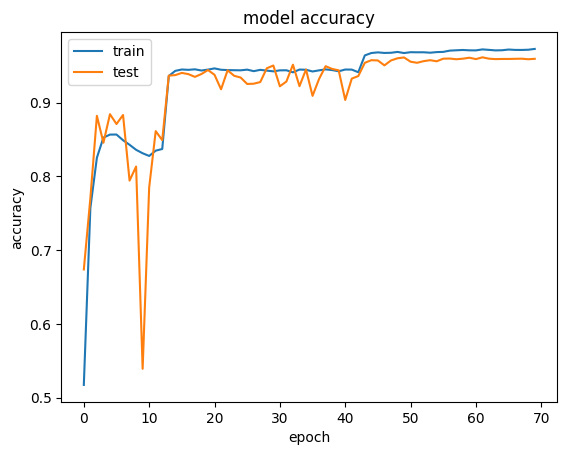

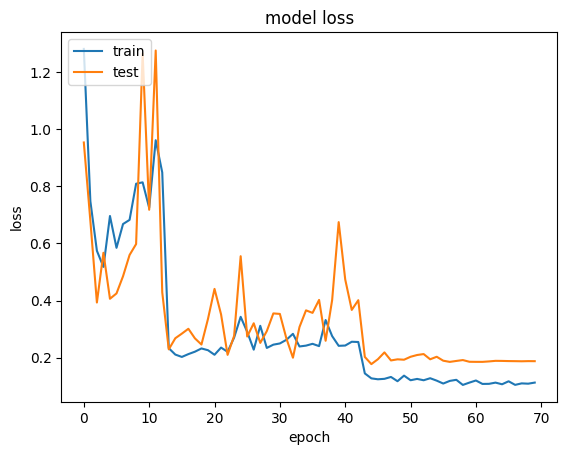

In [29]:
plt.plot(trainning.history['accuracy'])
plt.plot(trainning.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(trainning.history['loss'])
plt.plot(trainning.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [64]:
model_file = 'Model/M_MS_ResNet50.h5'

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  # what is the metric to measure
                                           patience=15,
                                           # how many epochs to continue running the model after seeing an increase in val_loss
                                           restore_best_weights=True)  # update the model with the best-seen weights?

reduce_LR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                              factor=0.1,
                                              patience=5)  # to make sure early_stop is what stops the model

checkpoint = keras.callbacks.ModelCheckpoint(filepath=model_file,
                                             monitor='val_loss',
                                             save_best_only=True)

callback_list = [reduce_LR, early_stop, checkpoint]

In [65]:

M_MS_ResNet50 = Sequential()
M_MS_ResNet50.add(resnet50)

M_MS_ResNet50.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 10)                23639562  
                                                                 
Total params: 23,639,562
Trainable params: 23,586,442
Non-trainable params: 53,120
_________________________________________________________________


In [66]:
# M_MS_ResNet50 = Sequential()
# M_MS_ResNet50.add(resnet50)
# M_MS_ResNet50.add(Flatten())
# M_MS_VGG16.add(Dropout(0.25))
# M_MS_ResNet50.add(Dense(512, activation='relu'))
# M_MS_ResNet50.add(Dense(num_classes, activation='softmax'))


In [67]:
for i in range(len(M_MS_ResNet50.weights)):
    M_MS_ResNet50.weights[i]._handle_name = str(i) + '/' + M_MS_ResNet50.weights[i].name
    


In [68]:
M_MS_ResNet50.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy', lr_metric])

M_MS_ResNet50.build(input_shape=input_shape_MS)


In [69]:
trainning = M_MS_ResNet50.fit(
    
    train_generator,
    steps_per_epoch=X_train.shape[0] // (batch_size*4),
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=X_test.shape[0] // (batch_size*4),
    callbacks=callback_list,
    
)

Epoch 1/200
337/337 [==============================] - 44s 96ms/step - loss: 2.8230 - accuracy: 0.1148 - lr: 1.0000e-16 - val_loss: 2.9354 - val_accuracy: 0.1064 - val_lr: 1.0000e-16
Epoch 2/200
337/337 [==============================] - 26s 76ms/step - loss: 2.8371 - accuracy: 0.1070 - lr: 1.0000e-16 - val_loss: 3.0551 - val_accuracy: 0.1049 - val_lr: 1.0000e-16
Epoch 3/200
337/337 [==============================] - 24s 70ms/step - loss: 2.8231 - accuracy: 0.1189 - lr: 1.0000e-16 - val_loss: 3.0100 - val_accuracy: 0.0975 - val_lr: 1.0000e-16
Epoch 4/200
337/337 [==============================] - 24s 71ms/step - loss: 2.8236 - accuracy: 0.1161 - lr: 1.0000e-16 - val_loss: 3.0331 - val_accuracy: 0.1190 - val_lr: 1.0000e-16
Epoch 5/200
337/337 [==============================] - 23s 68ms/step - loss: 2.8286 - accuracy: 0.1103 - lr: 1.0000e-16 - val_loss: 3.0042 - val_accuracy: 0.1064 - val_lr: 1.0000e-16
Epoch 6/200
337/337 [==============================] - 24s 71ms/step - loss: 2.8300 -

In [70]:
score = M_MS_ResNet50.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.001514196395874
Test accuracy: 0.10499999672174454


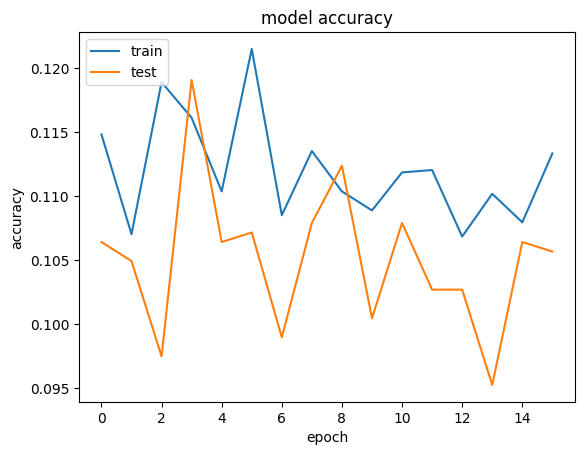

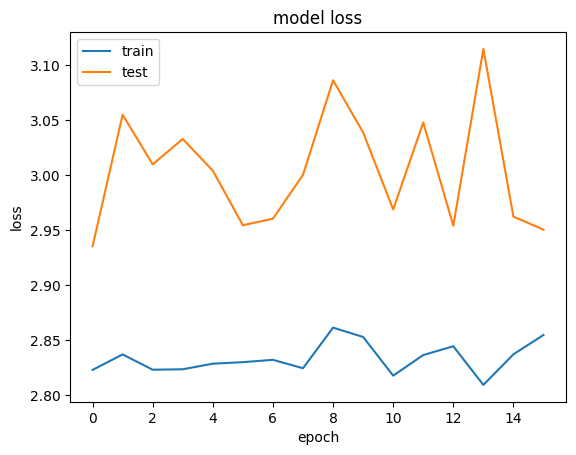

In [71]:
plt.plot(trainning.history['accuracy'])
plt.plot(trainning.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(trainning.history['loss'])
plt.plot(trainning.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()